In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, GRU, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer

2023-09-30 09:09:26.239164: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-30 09:09:28.071331: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-30 09:09:28.081202: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 09:09:31.762457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('../raw_data/sorted_feature_matrix.csv').drop(columns='Unnamed: 0')

In [3]:
df.isnull().sum()

Date                  0
Dividend              0
Volume                0
stock_price           0
fed_funds_rate        0
GDP                   0
Tickers               0
debt_to_equity        0
EPS                   0
return_on_equity      0
quick ratio           0
operating_ratio       0
inventory_turnover    0
pos_ma                0
neu_ma                0
neg_ma                0
dtype: int64

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32914 entries, 0 to 32913
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                32914 non-null  object 
 1   Dividend            32914 non-null  float64
 2   Volume              32914 non-null  float64
 3   stock_price         32914 non-null  float64
 4   fed_funds_rate      32914 non-null  float64
 5   GDP                 32914 non-null  float64
 6   Tickers             32914 non-null  object 
 7   debt_to_equity      32914 non-null  float64
 8   EPS                 32914 non-null  float64
 9   return_on_equity    32914 non-null  float64
 10  quick ratio         32914 non-null  float64
 11  operating_ratio     32914 non-null  float64
 12  inventory_turnover  32914 non-null  float64
 13  pos_ma              32914 non-null  float64
 14  neu_ma              32914 non-null  float64
 15  neg_ma              32914 non-null  float64
dtypes: f

## Todo
1. train-test-split
2. Standard scale float,
3. Create seq
4.  Model, embedding layer w mse and rmse


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
data = df.copy()

data


,Date,Dividend,Volume,stock_price,fed_funds_rate,GDP,Tickers,debt_to_equity,EPS,return_on_equity,quick ratio,operating_ratio,inventory_turnover,pos_ma,neu_ma,neg_ma
0,2018-01-31,0.00,5.315047e+06,51.919825,1.41,4500.182000,AAL,-134.253165,0.807713,-0.941772,0.484585,0.476713,1.930838,0.285655,5.198588e-01,1.944860e-01
1,2018-01-31,0.00,1.795523e+08,40.275178,1.41,4500.182000,AAPL,2.413301,2.970566,0.131828,1.098802,0.743752,9.811931,0.222114,6.974815e-01,8.040471e-02
2,2018-01-31,0.71,7.794467e+06,87.747239,1.41,4500.182000,ABBV,-23.651147,1.818001,-0.940431,1.083967,0.657965,1.027436,0.351660,3.990092e-01,2.493303e-01
3,2018-01-31,0.28,7.860137e+06,54.655791,1.41,4500.182000,ABT,1.333073,0.319962,0.018336,1.128287,0.829424,0.837345,0.323488,5.800269e-01,9.648529e-02
4,2018-01-31,0.00,1.614810e+06,29.889667,1.41,4500.182000,ACGL,2.331811,0.564373,0.024308,0.679544,0.278000,0.000000,0.000003,1.541489e-05,9.999820e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32909,2023-09-30,0.00,2.114983e+06,133.590376,5.08,5105.025000,YUM,-1.693220,1.487544,-0.049550,0.721587,0.427386,0.938914,0.008204,4.912204e-01,5.005759e-01
32910,2023-09-30,0.00,1.614090e+06,135.349948,5.08,5105.025000,ZBH,0.720673,1.004794,0.016942,0.945561,0.834571,0.230908,0.499998,5.000007e-01,1.404991e-06
32911,2023-09-30,0.00,3.709700e+05,274.414666,5.08,5053.623333,ZBRA,1.491979,2.802807,0.048128,0.502260,0.854987,0.732639,0.999969,2.603792e-05,5.176677e-06
32912,2023-09-30,0.00,5.042810e+06,28.125514,5.08,5105.025000,ZION,15.511452,1.181283,0.033125,0.458553,0.388889,-17.000000,1.000000,2.596820e-07,6.590589e-08


In [5]:
data['Tickers'] = data['Tickers'].astype('string')

data.dtypes

Date                  datetime64[ns]
Dividend                     float64
Volume                       float64
stock_price                  float64
fed_funds_rate               float64
GDP                          float64
Tickers               string[python]
debt_to_equity               float64
EPS                          float64
return_on_equity             float64
quick ratio                  float64
operating_ratio              float64
inventory_turnover           float64
pos_ma                       float64
neu_ma                       float64
neg_ma                       float64
dtype: object

In [6]:
data[data.select_dtypes(include=['float64']).columns] = data.select_dtypes(include = ['float64']).astype('float32')

In [7]:
data.dtypes

Date                  datetime64[ns]
Dividend                     float32
Volume                       float32
stock_price                  float32
fed_funds_rate               float32
GDP                          float32
Tickers               string[python]
debt_to_equity               float32
EPS                          float32
return_on_equity             float32
quick ratio                  float32
operating_ratio              float32
inventory_turnover           float32
pos_ma                       float32
neu_ma                       float32
neg_ma                       float32
dtype: object

## Train- Test- Split

In [8]:
# Split point based on the time period for testing
test_period = pd.DateOffset(months=12)

train_data = []
test_data = []

ticker_groups = data.groupby('Tickers')

for ticker, group in ticker_groups:
    # Sort the group data by date in ascending order
    group.sort_values(by='Date', inplace=True)
    
    # Calculate the split date for this ticker
    split_date = group['Date'].max() - test_period
    
    # Split the data for this ticker into training and testing sets
    train_group = group[group['Date'] < split_date]
    test_group = group[group['Date'] >= split_date]
    
    # Append the split data to the respective lists
    train_data.append(train_group)
    test_data.append(test_group)
    
train_df = pd.concat(train_data)
test_df = pd.concat(test_data)

In [9]:
X_train = train_df.drop(columns=['stock_price', 'Date'])
y_train = train_df['stock_price'].values

X_test = test_df.drop(columns=['stock_price', 'Date'])
y_test = test_df['stock_price'].values

In [10]:
scaler = MinMaxScaler()
# Fit the scaler to your training data and transform it
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include='float'))

# Transform your test data using the same scaler
X_test_scaled = scaler.transform(X_test.select_dtypes(include='float'))

## Model

In [11]:
max_features = 5  # Maximum number of words to get
max_len = 13  # Maximum sequence length
embedding_dim = 50  # Dimensionality of word embeddings

In [12]:
model = Sequential()

model.add(Embedding(max_features,embedding_dim, input_length= max_len))

model.add(GRU(64))

model.add(Dense(32,activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss= 'mse', optimizer= 'adam', metrics=['accuracy'])


2023-09-30 09:10:30.202347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-30 09:10:30.204553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-30 09:10:30.206574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 50)            250       
                                                                 
 gru (GRU)                   (None, 64)                22272     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 24,635
Trainable params: 24,635
Non-trainable params: 0
_________________________________________________________________


In [14]:
batch_size = 32
epochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


2023-09-30 09:10:46.747093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-30 09:10:46.750422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-30 09:10:46.752158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

666/667 [============================>.] - ETA: 0s - loss: 84659.5391 - accuracy: 0.0000e+00

2023-09-30 09:11:05.745540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-30 09:11:05.749537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-30 09:11:05.753141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

667/667 [==============================] - 21s 27ms/step - loss: 84637.7578 - accuracy: 0.0000e+00 - val_loss: 24836.5742 - val_accuracy: 0.0000e+00
Epoch 2/100
667/667 [==============================] - 15s 23ms/step - loss: 84634.0312 - accuracy: 0.0000e+00 - val_loss: 24836.5723 - val_accuracy: 0.0000e+00
Epoch 3/100
667/667 [==============================] - 14s 21ms/step - loss: 84634.0312 - accuracy: 0.0000e+00 - val_loss: 24836.5723 - val_accuracy: 0.0000e+00
Epoch 4/100
667/667 [==============================] - 13s 19ms/step - loss: 84633.9062 - accuracy: 0.0000e+00 - val_loss: 24836.5723 - val_accuracy: 0.0000e+00
Epoch 5/100
667/667 [==============================] - 14s 21ms/step - loss: 84634.0156 - accuracy: 0.0000e+00 - val_loss: 24836.5723 - val_accuracy: 0.0000e+00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


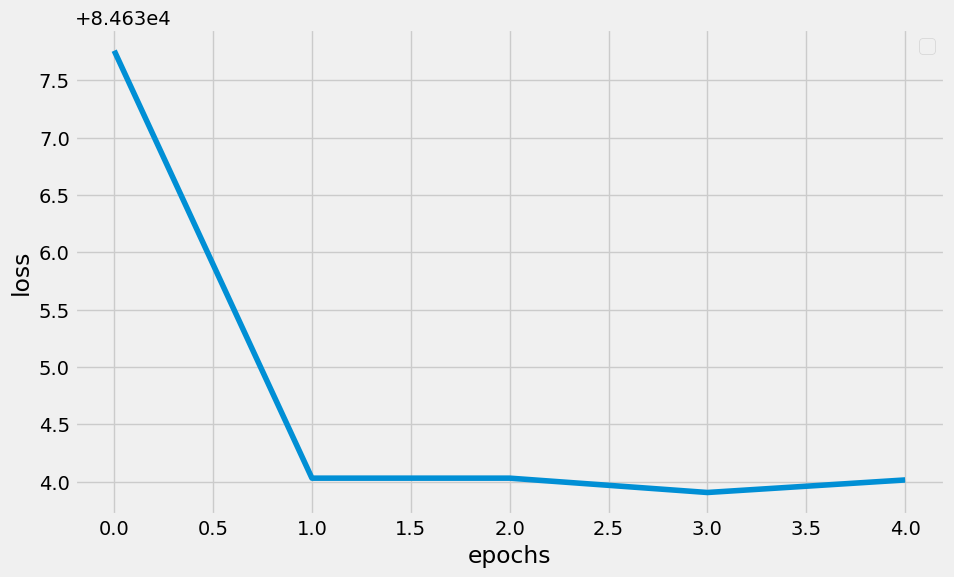

In [15]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

196/196 [==============================] - 1s 4ms/step - loss: 127798.3906 - accuracy: 0.0000e+00
Test loss: 127798.3906
Test accuracy: 0.0000


## Model Predicting

In [17]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real')
    plt.plot(predicted, color='blue',label='Predicted')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend() 
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))